# Project - First Requirement

### Include packages.

In [22]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm    # Just to plot distribution of valuations
from scipy import optimize

### The first thing to do is to code the environment.

In [23]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

### In this setting, the environment is responsible for telling the seller about the reward.

In [24]:
class PricingEnvironmentSingleProduct(Environment):
    def __init__(self, cost, mean_valuation, std_valuation, buyers_per_round):
        self.cost = cost
        self.mean_valuation = mean_valuation
        self.std_valuation = std_valuation
        self.buyers_per_round = buyers_per_round

    def round(self, p_t):
        # Probability of a single customer buying at price p_t
        # 1 - CDF(p_t) for a normal distribution with mean_valuation and std_valuation
        prob_buy = 1 - norm.cdf(p_t, loc=self.mean_valuation, scale=self.std_valuation)

        # Number of sales is drawn from a binomial distribution
        num_of_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)

        reward = (p_t - self.cost) * num_of_sales
        return num_of_sales, reward

### Now define the setting...

In [25]:
# --- Global Settings ---

np.random.seed(30)

T = 20000                 # Time horizon (number of rounds)
n_trials = 10             # Number of independent trials for averaging
N = 1                     # Number of products (unused in this version)

# --- Pricing Grid and Product Info ---

min_p = 0.0
max_p = 5.0
price_step = 0.5
P = np.linspace(min_p, max_p, int((max_p - min_p) / price_step) + 1)  # Discrete set of prices
K = len(P)                        # Number of price options (arms)

cost = 2.00                       # Unit production cost
value = 3.00                      # True mean customer valuation
std_valuation = 1.0               # Standard deviation of customer valuations

assert cost < value, "Cost must be less than value"

# --- Market and Inventory Parameters ---

B = 120000                         # Total inventory available (seller capacity)

# --- Derived Buyer Generation per Round ---

buyers_per_round = 50
assert buyers_per_round >= 1, "Must have at least one buyer per round"

# --- Other Parameters ---

zoom = 0.001              # Zoom factor for plotting
s = 30                    # random seed

### Expected demand and profit using theoretical expectations.

In [26]:
# In our setting, customer valuations are drawn from a normal distribution.
# Given this assumption, we can analytically compute the expected demand at each price p.
# It can be proven that the expected demand is given by: 

def expected_demand(p):
    return np.sum(1 - norm.cdf(p, loc=np.full(buyers_per_round, value), scale=1.0))

# This results in a smooth probability-based estimation of demand for each price p,
# where the probability for a single customer to buy is the tail area of the normal distribution beyond p.

expected_demand_vector = np.array([expected_demand(p) for p in P])
expected_profit_vector = (P - cost) * expected_demand_vector

best_expected_index = np.argmax(expected_profit_vector)
best_expected_price = P[best_expected_index]
best_expected_profit = expected_profit_vector[best_expected_index]

### Let us visualize our setting.

Max expected profit (theoretical): 25.0
...at price: 3.0


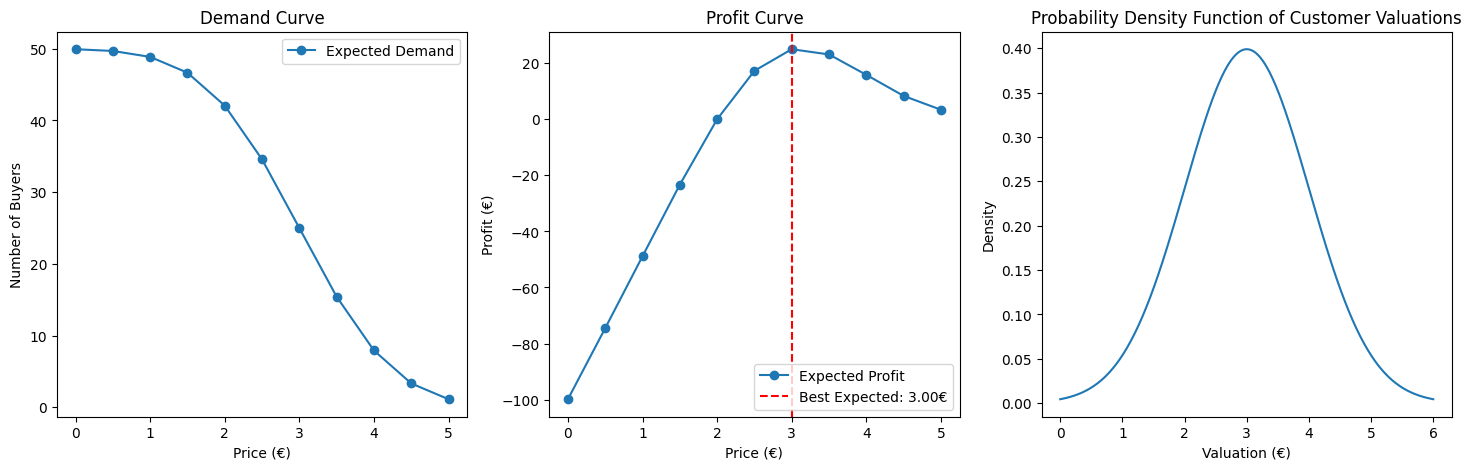

In [27]:
# --- Summary of Results ---

print("Max expected profit (theoretical):", round(best_expected_profit, 2))
print("...at price:", round(best_expected_price, 2))

# --- Plots: Expected vs Realized Demand and Profit ---

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Demand comparison
axs[0].plot(P, expected_demand_vector, label='Expected Demand', marker='o')
axs[0].set_title("Demand Curve")
axs[0].set_xlabel("Price (€)")
axs[0].set_ylabel("Number of Buyers")
axs[0].legend()

# Profit comparison
axs[1].plot(P, expected_profit_vector, label='Expected Profit', marker='o')
axs[1].axvline(best_expected_price, color='r', linestyle='--', label=f"Best Expected: {best_expected_price:.2f}€")
axs[1].set_title("Profit Curve")
axs[1].set_xlabel("Price (€)")
axs[1].set_ylabel("Profit (€)")
axs[1].legend()

# Additional plot for the PDF of customer valuations
x_vals = np.linspace(min_p, max_p * 1.2, 500) # Extend range slightly for visualization
axs[2].plot(x_vals, norm.pdf(x_vals, loc=value, scale=std_valuation))
axs[2].set_title("Probability Density Function of Customer Valuations")
axs[2].set_xlabel("Valuation (€)")
_ = axs[2].set_ylabel("Density")

### How can I interact with this environment? We use Agents.

In [28]:
class Agent:
    def __init__(self):
        pass
    def pull_arm(self):
        pass
    def update(self, r_t):
        pass

### Define the UCB1 Agent.

In [29]:
# If rewards lie in [0, R], you must scale the confidence term by self.range = R maximum possible reward in a round t.
R = ( max(P) - cost ) * buyers_per_round

class UCB1Agent(Agent):
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K: # In the first K rounds, we sample each arm once
            self.a_t = self.t
        else:   
            ucbs = self.average_rewards + self.range * np.sqrt( 2 * np.log(self.T) / self.N_pulls )
            self.a_t = np.argmax(ucbs)
        return self.a_t

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += ( r_t - self.average_rewards[self.a_t] ) / self.N_pulls[self.a_t]
        self.t += 1

### E.g. Instantaneous Regret - Single run.

Expected best price: 3.0


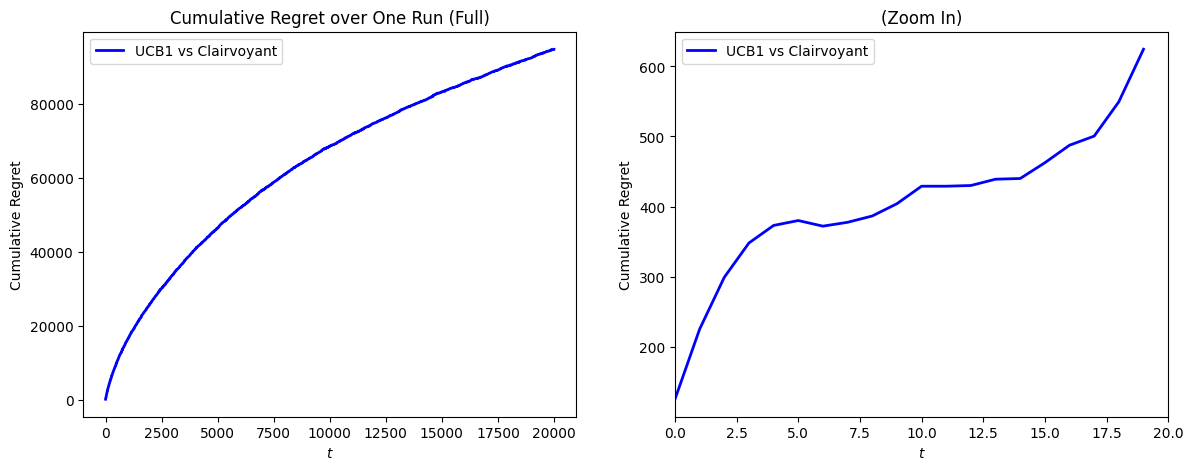

In [30]:
# --- Single run to compare realized rewards ---

# The clairvoyant benchmark in a stochastic environment is the expected reward of the optimal arm.
clairvoyant_expected_rewards = np.repeat(best_expected_profit, T)

# Initialize the stochastic environment
np.random.seed(s)
env = PricingEnvironmentSingleProduct(cost=cost, mean_valuation=value, std_valuation=std_valuation, buyers_per_round=buyers_per_round)

# Run UCB1
ucb_agent = UCB1Agent(K, T, range=R)
agent_rewards = np.array([])
pull_counts = np.zeros(K, dtype=int)  # <-- Track number of times each arm is pulled
for t in range(T):
    pi_t = ucb_agent.pull_arm()
    p_t = P[pi_t]
    d_t, r_t = env.round(p_t)
    ucb_agent.update(r_t)
    agent_rewards = np.append(agent_rewards, r_t)
    pull_counts[pi_t] += 1

# Compute most played price
most_played_action = np.argmax(pull_counts)
most_played_price = P[most_played_action]

# Compute realized regret
expected_regret = np.cumsum(clairvoyant_expected_rewards - agent_rewards)

print("Expected best price:", round(best_expected_price, 2))

# --- Plots ---

zoom_T = int(T * zoom)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

# Full
ax1.plot(np.arange(T), expected_regret, 'b-', linewidth=2, label='UCB1 vs Clairvoyant')
ax1.set_title('Cumulative Regret over One Run (Full)')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Cumulative Regret')
ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

# Zoom In
ax2.plot(np.arange(zoom_T), expected_regret[:zoom_T], 'b-', linewidth=2, label='UCB1 vs Clairvoyant')
ax2.set_xlim(0, zoom_T)
ax2.set_title('(Zoom In)')
ax2.set_xlabel('$t$')
ax2.set_ylabel('Cumulative Regret')
_ = ax2.legend()


### Let's see in which arms the algorithm spent more time.

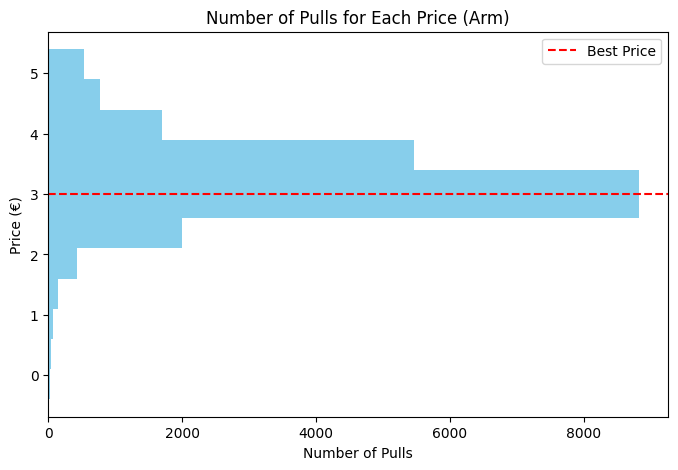

In [31]:
# --- UCB1 Agent ---
plt.figure(figsize=(8, 5))
plt.barh(P, ucb_agent.N_pulls, color='skyblue')
plt.axhline(P[best_expected_index], color='red', linestyle='--', label='Best Price')
plt.xlabel('Number of Pulls')
plt.ylabel('Price (€)')
plt.title('Number of Pulls for Each Price (Arm)')
_ = plt.legend()

### Pseudo Regret - Estimation


Since it is very complex to compute the theoretical Expected Regret (nor Pseudo) at each round - due to the complex stochasticity in the choice of the action... We estimate it by computing it as the average cumulative regret per round, over many trials. To do this, we use the expected reward of both the clairvoyant and the agent actions, to reduce the variability of the estimation.

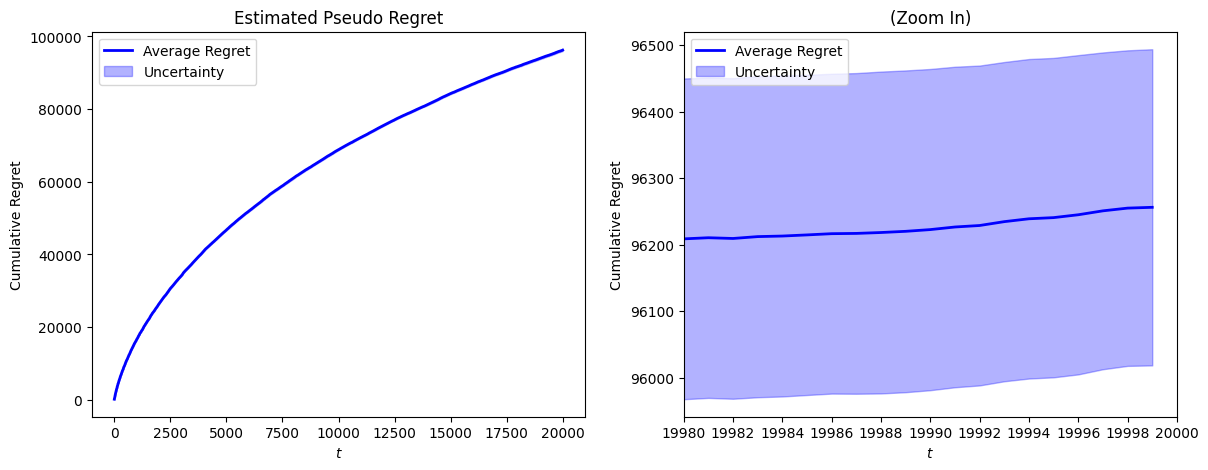

In [32]:
# Compute cumulative regret over multiple trials
regret_per_trial = []
expected_clairvoyant_rewards = np.repeat(best_expected_profit, T) 

for seed in range(n_trials):
    # Initialize the stochastic environment for each trial
    np.random.seed(seed)
    env = PricingEnvironmentSingleProduct(cost=cost, mean_valuation=value, std_valuation=std_valuation, buyers_per_round=buyers_per_round)
    
    # Initialize
    ucb_agent = UCB1Agent(K, T, range=R)
    agent_rewards = np.array([])

    # Run UCB1 for T rounds
    for t in range(T):
        pi_t = ucb_agent.pull_arm()
        p_t = P[pi_t]
        d_t, r_t = env.round(p_t)
        ucb_agent.update(r_t)
        agent_rewards = np.append(agent_rewards, r_t)

    # Store cumulative regret for this trial
    cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)
    regret_per_trial.append(cumulative_regret)

# Compute average (and standard deviation) of regret
average_regret = np.array(regret_per_trial).mean(axis=0)
regret_sd = np.array(regret_per_trial).std(axis=0)

# --- Plot regret ---

# Set zoom start time based on the zoom factor
zoom_start_t = max(0, T - max(1, int(T * zoom)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

# Full Plot (now on the left)
ax1.plot(np.arange(T), average_regret, 'b-', linewidth=2, label='Average Regret')
ax1.fill_between(np.arange(T), average_regret - regret_sd / np.sqrt(n_trials), average_regret + regret_sd / np.sqrt(n_trials), alpha=0.3, color='blue', label='Uncertainty')
ax1.set_title('Estimated Pseudo Regret')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Cumulative Regret')
ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

# Zoom In (now on the right)
ax2.plot(np.arange(zoom_start_t, T), average_regret[zoom_start_t:], 'b-', linewidth=2, label='Average Regret')
ax2.fill_between(np.arange(zoom_start_t, T), (average_regret - regret_sd / np.sqrt(n_trials))[zoom_start_t:], (average_regret + regret_sd / np.sqrt(n_trials))[zoom_start_t:], alpha=0.3, color='blue', label='Uncertainty')
ax2.set_xlim(zoom_start_t, T)
ax2.set_title('(Zoom In)')
ax2.set_xlabel('$t$')
ax2.set_ylabel('Cumulative Regret')
ax2.legend()
ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

### Let's introduce a maximum capacity for the seller: UCB-LIKE AGENT.

In [ ]:
# --- Agent ---
class UCBLikeInventoryAgent():
    def __init__(self, K, B, T, range=1):
        self.K = K                      # Number of prices
        self.T = T                      # Horizon
        self.range = range              # Confidence scaling factor
        self.a_t = None                 # Last chosen arm index
        self.avg_f = np.zeros(K)        # Average reward per arm
        self.avg_c = np.zeros(K)        # Average consumption per arm
        self.N_pulls = np.zeros(K)      # Number of pulls per arm
        self.inventory = B              # Total inventory
        self.rho = B / T                # Average allowed consumption per round
        self.t = 0                      # Current round

    # We may want to track the gamma distribution over t, so we add the option
    def pull_arm(self, return_gamma=False):
        if self.inventory < 1:
            self.a_t = None
            return (None, None) if return_gamma else None

        if self.t < self.K:
            self.a_t = self.t
            gamma = np.zeros(self.K)
            gamma[self.a_t] = 1.0
        else:
            f_ucbs = self.avg_f + self.range * np.sqrt(2 * np.log(self.T) / self.N_pulls)
            c_lcbs = self.avg_c - self.range * np.sqrt(2 * np.log(self.T) / self.N_pulls)
            gamma = self.compute_opt(f_ucbs, c_lcbs)
            self.a_t = np.random.choice(self.K, p=gamma)

        return (self.a_t, gamma) if return_gamma else self.a_t

    def compute_opt(self, f_ucbs, c_lcbs):
        # If all LCBs are zero or negative, fallback to greedy
        if np.sum(c_lcbs <= np.zeros(self.K)) == self.K:
            gamma = np.zeros(self.K)
            gamma[np.argmax(f_ucbs)] = 1
            return gamma
        
        # Solve the linear program
        c = -f_ucbs
        A_ub = [c_lcbs]
        b_ub = [self.rho]
        A_eq = [np.ones(self.K)]
        b_eq = [1]
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1), method='highs')
        gamma = res.x
        return gamma

    def update(self, f_t, c_t):
        self.N_pulls[self.a_t] += 1
        self.avg_f[self.a_t] += (f_t - self.avg_f[self.a_t]) / self.N_pulls[self.a_t]
        self.avg_c[self.a_t] += (c_t - self.avg_c[self.a_t]) / self.N_pulls[self.a_t]
        self.inventory -= c_t
        self.t += 1

### Compute the regret for our new algorithm.

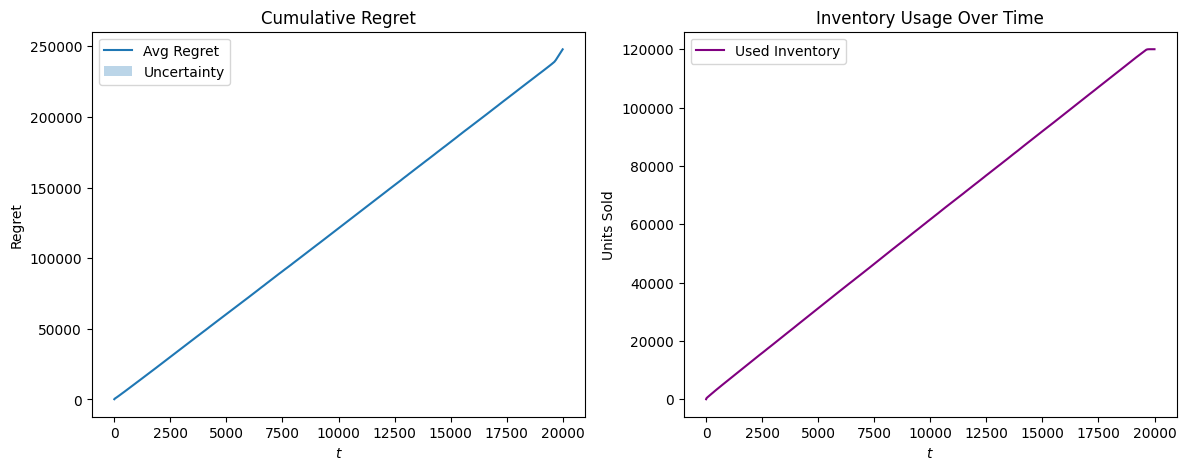

In [34]:
# Compute cumulative regret over multiple trials
regret_per_trial = []
inventory_per_trial = []
expected_clairvoyant_rewards = np.repeat(best_expected_profit, T)

for seed in range(n_trials):
    
    # To visualize the chosen arms by the algorithm and the probability that the algorithm chooses the best price at each round t
    # We take this information from the last trial (as an example)
    if seed == n_trials - 1:
        actions_in_time = []
        gamma_best_trace = []
    
    # Create environment using new valuations
    np.random.seed(seed)
    env = PricingEnvironmentSingleProduct(cost=cost, mean_valuation=value, std_valuation=std_valuation, buyers_per_round=buyers_per_round)
    
    # Initialize
    ucb_like_agent = UCBLikeInventoryAgent(K=K, B=B, T=T, range=1)
    agent_rewards = []
    inventory_trace = []

    # Run UCB1 for T rounds
    for t in range(T):

        pi_t = ucb_like_agent.pull_arm()

        # If the inventory is exhausted, we can break the loop
        if pi_t is None:
            agent_rewards.extend([0] * (T - t))
            inventory_trace.extend([ucb_like_agent.inventory] * (T - t))
            break

        # If it's the last trial, we want to store the information
        if seed == n_trials - 1:
            actions_in_time.append(P[pi_t])
        
        # Otherwise, proceed 
        p_t = P[pi_t]
        d_t, r_t = env.round(p_t)
        ucb_like_agent.update(f_t=r_t, c_t=d_t)
        agent_rewards.append(r_t)
        inventory_trace.append(ucb_like_agent.inventory)

    # Store cumulative regret for this trial
    cumulative_regret = np.cumsum(expected_clairvoyant_rewards - np.array(agent_rewards))
    regret_per_trial.append(cumulative_regret)
    inventory_per_trial.append(inventory_trace)

# --- Compute stats ---
average_regret = np.mean(regret_per_trial, axis=0)
regret_sd = np.std(regret_per_trial, axis=0)

average_inventory = np.mean(inventory_per_trial, axis=0)
inventory_used = B - average_inventory  # cumulative consumption

# --- Plot: Regret and Budget Usage ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Regret plot
ax1.plot(np.arange(T), average_regret, label='Avg Regret')
ax1.fill_between(np.arange(T), average_regret - regret_sd / np.sqrt(n_trials), average_regret + regret_sd / np.sqrt(n_trials), alpha=0.3, label='Uncertainty')
ax1.set_title('Cumulative Regret')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Regret')
ax1.legend()

# Inventory usage plot
ax2.plot(np.arange(T), inventory_used, label='Used Inventory', color='purple')
ax2.set_title('Inventory Usage Over Time')
ax2.set_xlabel('$t$')
ax2.set_ylabel('Units Sold')
_ = ax2.legend()

### What?? Linear regret?!

What we will notice in the following analysis, is that we should take care of what kind of clairvoyant we are assuming, in order to compare our rewards with the clairvoyant rewards...

 But let's first have a look to the behaviour of the agent with capacity constraint. In the next cell, we can see that the optimal price appears to be too "cheap" (or too "expensive" with respect to the budget consumption) to be played. The algorithm basically learns a mix which is much better than playing the optimal price, because by playing the optimal price we would finish the items in the inventory very early, while we could even be patient and take some time to try to sell at a higher price the fixed number of articles B.

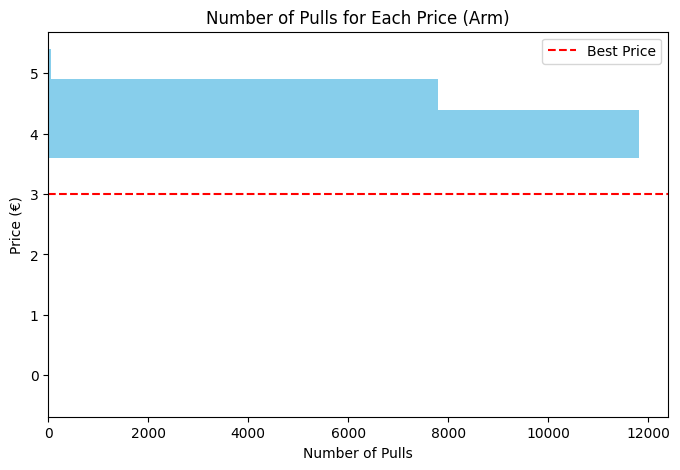

In [ ]:
# --- Chosen arms on the alst trial ---
plt.figure(figsize=(8, 5))
plt.barh(P, ucb_like_agent.N_pulls, color='skyblue') 
plt.axhline(P[best_expected_index], color='red', linestyle='--', label='Best Price') 
plt.xlabel('Number of Pulls')
plt.ylabel('Price (€)')
plt.title('Number of Pulls for Each Price (Arm)')
_ = plt.legend()

And it is pretty fast to learn that!

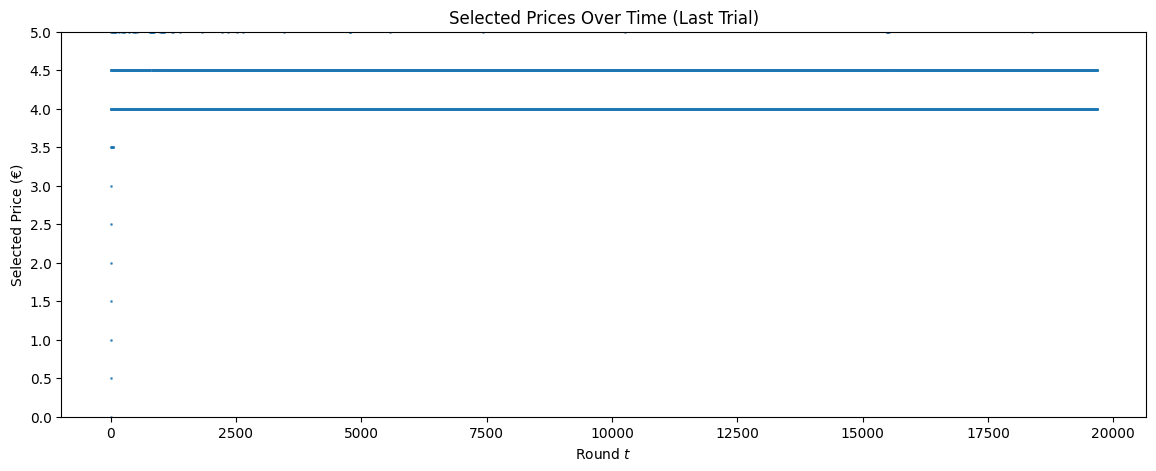

In [36]:
# Take the enumeration of the rounds
rounds_last = np.arange(len(actions_in_time))

# --- Plot: Selected Prices Over Time (Last Trial) ---
plt.figure(figsize=(14, 5))
plt.plot(rounds_last, actions_in_time, '.', markersize=2, alpha=0.7)
plt.title("Selected Prices Over Time (Last Trial)")
plt.xlabel("Round $t$")
plt.ylabel("Selected Price (€)")
plt.yticks(np.arange(0, 5.5, 0.5))
_ = plt.ylim(0, 5)


Finally, let's now discuss the clairvoyant definition. From the previous regret plot, it seems that the regret is not as good as we would expect, given the theoretical guarantees. The reason in this case is that we are comparing an algorithm playing with a max capacity - thus looking for a mix which lets it save items until the very latest rounds - against a clairvoyant which can keep selling as many items as wanted at each round. Thus, it's clear that the regret gets linear: the algorithm is literally never playing the optimal move.

In the following analysis, we will show that even the fixed-arm clairvoyant actually does not win over our algorithm, in the given setting of a fixed maximum capacity. We also provide the comparison with a mixed optimal strategy - that we will call mixed-strategy clairvoyant.

In [ ]:
# --- Clairvoyant fixed price under inventory constraint ---

expected_profits = []
expected_units = []

# Compute expected total profit for each price, under the inventory constraint B
for p, d in zip(P, expected_demand_vector):
    total_units = d * T                         # total units that could be sold at price p (if unlimited inventory)
    capped_units = min(total_units, B)          # actual units that can be sold given the inventory constraint
    profit = (p - cost) * capped_units          # expected total profit at this price
    expected_profits.append(profit)
    expected_units.append(capped_units)

expected_profits = np.array(expected_profits)
expected_units = np.array(expected_units)

# Select the best fixed price (clairvoyant choice under constraint)
best_index = np.argmax(expected_profits)
best_price = P[best_index]
best_profit = expected_profits[best_index]

# Print results for the fixed-price clairvoyant
print(f"--- Fixed Price Clairvoyant ---")
print(f"Best price: {best_price:.2f}")
print(f"Expected total profit: {best_profit:.2f}")

# Compute reward vector over T rounds for this fixed price
price_fixed = best_price
demand_fixed = expected_demand_vector[best_index]
reward_per_round_fixed = (price_fixed - cost) * demand_fixed

max_rounds_full = int(B // demand_fixed)        # how many full rounds can be executed
remaining_budget = B - (max_rounds_full * demand_fixed)
partial_reward = (price_fixed - cost) * remaining_budget if remaining_budget > 0 else 0

clairvoyant_rewards_fixed = np.zeros(T)
clairvoyant_rewards_fixed[:max_rounds_full] = reward_per_round_fixed
if max_rounds_full < T:
    clairvoyant_rewards_fixed[max_rounds_full] = partial_reward

# --- Clairvoyant mixed strategy under capacity constraint ---

expected_rewards = (P - cost) * expected_demand_vector
expected_costs = expected_demand_vector
rho = B / T                 # average budget per round

# Solve LP to find optimal randomized (mixed) pricing strategy under capacity constraint
c = -expected_rewards       # we maximize reward → minimize negative reward
A_ub = [expected_costs]     # constraint: average cost per round <= rho
b_ub = [rho]
A_eq = [np.ones(K)]         # probabilities must sum to 1
b_eq = [1]

res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1), method='highs')
gamma_star = res.x          # optimal price distribution (clairvoyant mixed strategy)
clairvoyant_mixed_reward_per_round = np.dot(gamma_star, expected_rewards)
clairvoyant_mixed_total_reward = clairvoyant_mixed_reward_per_round * T
clairvoyant_rewards_mixed = np.full(T, clairvoyant_mixed_reward_per_round)

# Print results for the mixed-strategy clairvoyant
print(f"\n--- Mixed Strategy Clairvoyant ---")
print(f"Optimal mixed strategy: {np.round(gamma_star, 2)}")
print(f"Expected total reward: {clairvoyant_mixed_total_reward:.2f}")

# --- Learnt vs Clairvoyant Rewards ---

f_ucbs = ucb_like_agent.avg_f + ucb_like_agent.range * np.sqrt(2 * np.log(ucb_like_agent.T) / ucb_like_agent.N_pulls)
c_lcbs = ucb_like_agent.avg_c - ucb_like_agent.range * np.sqrt(2 * np.log(ucb_like_agent.T) / ucb_like_agent.N_pulls)
gamma = ucb_like_agent.compute_opt(f_ucbs, c_lcbs)

print(f"\n--- Learnt (dynamic) mixed strategy ---")
print(f"Optimal mixed strategy: {np.round(gamma, 2)}")
print(f"Total reward: {np.array(agent_rewards).sum():.2f}")


--- Fixed Price Clairvoyant ---
Best price: 4.00
Expected total profit: 240000.00

--- Mixed Strategy Clairvoyant ---
Optimal mixed strategy: [0.   0.   0.   0.   0.   0.   0.   0.   0.58 0.42 0.  ]
Expected total reward: 254058.27

--- Learnt (dynamic) mixed strategy ---
Optimal mixed strategy: [0.   0.   0.   0.   0.   0.   0.   0.   0.59 0.41 0.  ]
Total reward: 252243.00


### Visualize.

Final value of the regret vs fixed clairvoyant: -12186.350000005157
Final value of the regret vs mixed clairvoyant: 1871.9193624673167


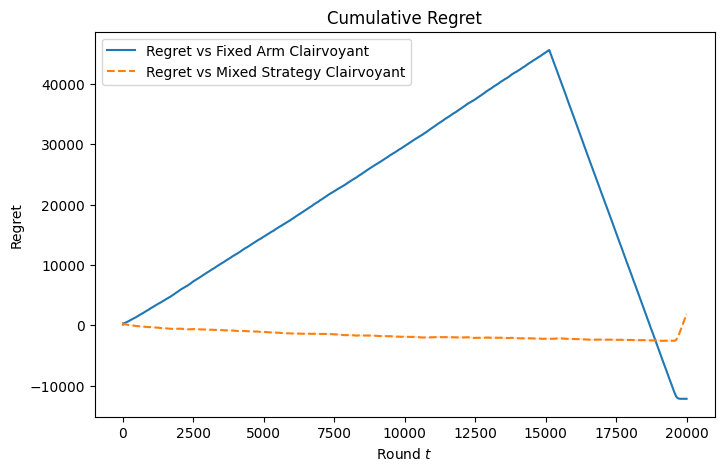

In [38]:
# --- Run algorithm and compute regret against both baselines ---

regret_vs_fixed = []
regret_vs_mixed = []
inventory_trace_list = []

for seed in range(n_trials):

    if seed == n_trials - 1:
        actions_in_time = []

    # Initialize the stochastic environment for each trial
    np.random.seed(seed)
    env = PricingEnvironmentSingleProduct(cost=cost, mean_valuation=value, std_valuation=std_valuation, buyers_per_round=buyers_per_round)

    ucb_like_agent = UCBLikeInventoryAgent(K=K, B=B, T=T, range=1)
    rewards = []
    inventory_trace = []

    # Run UCB-like agent for T rounds
    for t in range(T):
        pi_t = ucb_like_agent.pull_arm()

        if pi_t is None:
            rewards.extend([0] * (T - t))
            inventory_trace.extend([ucb_like_agent.inventory] * (T - t))
            break

        if seed == n_trials - 1:
            actions_in_time.append(P[pi_t])

        price = P[pi_t]
        demand, reward = env.round(price)
        ucb_like_agent.update(f_t=reward, c_t=demand)
        rewards.append(reward)
        inventory_trace.append(ucb_like_agent.inventory)

    # Store cumulative regret for this trial
    rewards = np.array(rewards)
    regret_vs_fixed.append(np.cumsum(clairvoyant_rewards_fixed - rewards))
    regret_vs_mixed.append(np.cumsum(clairvoyant_rewards_mixed - rewards))
    inventory_trace_list.append(inventory_trace)

# --- Compute stats ---

avg_regret_fixed = np.mean(regret_vs_fixed, axis=0)
std_regret_fixed = np.std(regret_vs_fixed, axis=0)

avg_regret_mixed = np.mean(regret_vs_mixed, axis=0)
std_regret_mixed = np.std(regret_vs_mixed, axis=0)

avg_inventory_used = B - np.mean(inventory_trace_list, axis=0)

# --- Plots ---

plt.figure(figsize=(8, 5))

# Plot regret vs fixed clairvoyant
plt.plot(avg_regret_fixed, label='Regret vs Fixed Arm Clairvoyant')
plt.fill_between(np.arange(T), avg_regret_fixed - std_regret_fixed / np.sqrt(n_trials), avg_regret_fixed + std_regret_fixed / np.sqrt(n_trials), alpha=0.2)

# Plot regret vs mixed clairvoyant
plt.plot(avg_regret_mixed, label='Regret vs Mixed Strategy Clairvoyant', linestyle='--')
plt.fill_between(np.arange(T), avg_regret_mixed - std_regret_mixed / np.sqrt(n_trials), avg_regret_mixed + std_regret_mixed / np.sqrt(n_trials), alpha=0.2)

print("Final value of the regret vs fixed clairvoyant:", avg_regret_fixed[-1])
print("Final value of the regret vs mixed clairvoyant:", avg_regret_mixed[-1])

# Styling
plt.title("Cumulative Regret")
plt.xlabel("Round $t$")
plt.ylabel("Regret")
_ = plt.legend()